In [1]:
import pandas as pd
import re

import numpy as np
import matplotlib.pyplot as plt


with open('epa-http.txt', 'r') as file:
    logs = file.readlines()
    
pattern = r'(\S+) \[(\d+:\d+:\d+:\d+)\] "(\w+) (\S+) (\S+)" (\d+) (\d+)'


# Списки для данных
ip_addresses = []
timestamps = []
methods = []
paths = []
protocols = []
status_codes = []
response_sizes = []

# Парсинг логов
for log in logs:
    match = re.match(pattern, log)
    if match:
        ip, timestamp, method, path, protocol, status_code, response_size = match.groups()
        ip_addresses.append(ip)
        timestamps.append(timestamp)
        methods.append(method)
        paths.append(path)
        protocols.append(protocol)
        status_codes.append(status_code)
        response_sizes.append(response_size)

# Создание датафрейма
df = pd.DataFrame({
    'Domain': ip_addresses,
    'Timestamp': timestamps,
    'Method': methods,
    'Path': paths,
    'Protocol': protocols,
    'Status_Code': status_codes,
    'Response_Size': response_sizes
})

# Вывод датафрейма
print(df)

                        Domain    Timestamp Method  \
0                141.243.1.172  29:23:53:25    GET   
1      query2.lycos.cs.cmu.edu  29:23:53:36    GET   
2             tanuki.twics.com  29:23:53:53    GET   
3           wpbfl2-45.gate.net  29:23:54:15    GET   
4           wpbfl2-45.gate.net  29:23:54:16    GET   
...                        ...          ...    ...   
42343     www-e5.proxy.aol.com  30:23:52:39    GET   
42344     jhws19.aca.ilstu.edu  30:23:52:44    GET   
42345     jhws19.aca.ilstu.edu  30:23:52:45    GET   
42346     www-e5.proxy.aol.com  30:23:53:06    GET   
42347     jhws19.aca.ilstu.edu  30:23:53:07    GET   

                                                    Path  Protocol  \
0                                         /Software.html  HTTP/1.0   
1                                         /Consumer.html  HTTP/1.0   
2                                             /News.html  HTTP/1.0   
3                                                      /  HTTP/1.0   
4

In [2]:
# Преобразование строки времени в timedelta
df['Timestamp'] = df['Timestamp'].apply(lambda x: pd.to_timedelta(x.split(":")[0] + ' days ' + x.split(":")[1] + ' hours ' + x.split(":")[2] + ' minutes ' + x.split(":")[3] + ' seconds'))

# Вычитание минимального значения
df['Timestamp'] = df['Timestamp'] - df['Timestamp'].min()

# Преобразование timedelta в datetime
start_date = pd.Timestamp.now().normalize()  # начало текущего дня
df['ds'] = df['Timestamp'].apply(lambda x: start_date + x)
df.drop('Timestamp', axis=1, inplace=True)

print(df)
data = df

                        Domain Method  \
0                141.243.1.172    GET   
1      query2.lycos.cs.cmu.edu    GET   
2             tanuki.twics.com    GET   
3           wpbfl2-45.gate.net    GET   
4           wpbfl2-45.gate.net    GET   
...                        ...    ...   
42343     www-e5.proxy.aol.com    GET   
42344     jhws19.aca.ilstu.edu    GET   
42345     jhws19.aca.ilstu.edu    GET   
42346     www-e5.proxy.aol.com    GET   
42347     jhws19.aca.ilstu.edu    GET   

                                                    Path  Protocol  \
0                                         /Software.html  HTTP/1.0   
1                                         /Consumer.html  HTTP/1.0   
2                                             /News.html  HTTP/1.0   
3                                                      /  HTTP/1.0   
4                           /icons/circle_logo_small.gif  HTTP/1.0   
...                                                  ...       ...   
42343            

In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Response_Size'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -204.83666886662084
p-value: 0.0


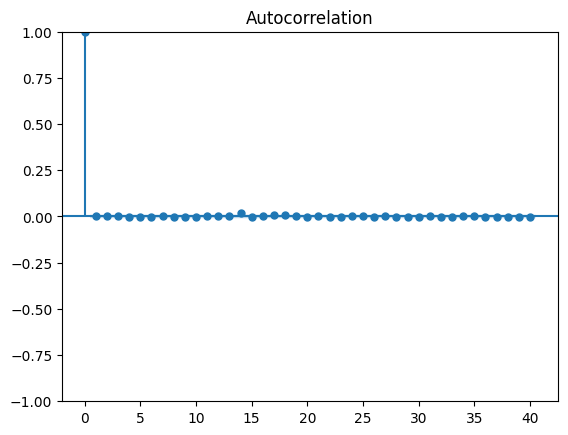

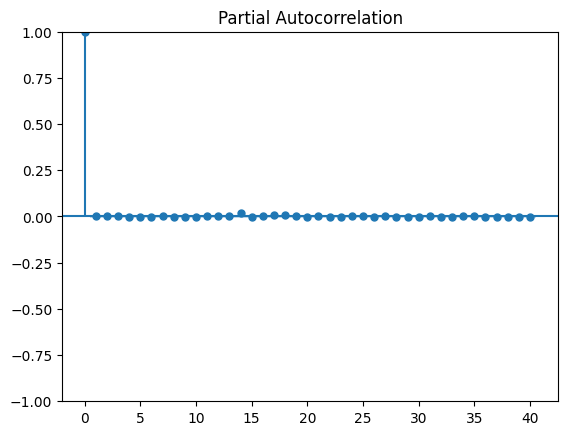

In [21]:
plot_acf(df['Response_Size'], lags=40)
plt.show()

plot_pacf(df['Response_Size'], lags=40)
plt.show()

23:47:14 - cmdstanpy - INFO - Chain [1] start processing
23:47:16 - cmdstanpy - INFO - Chain [1] done processing


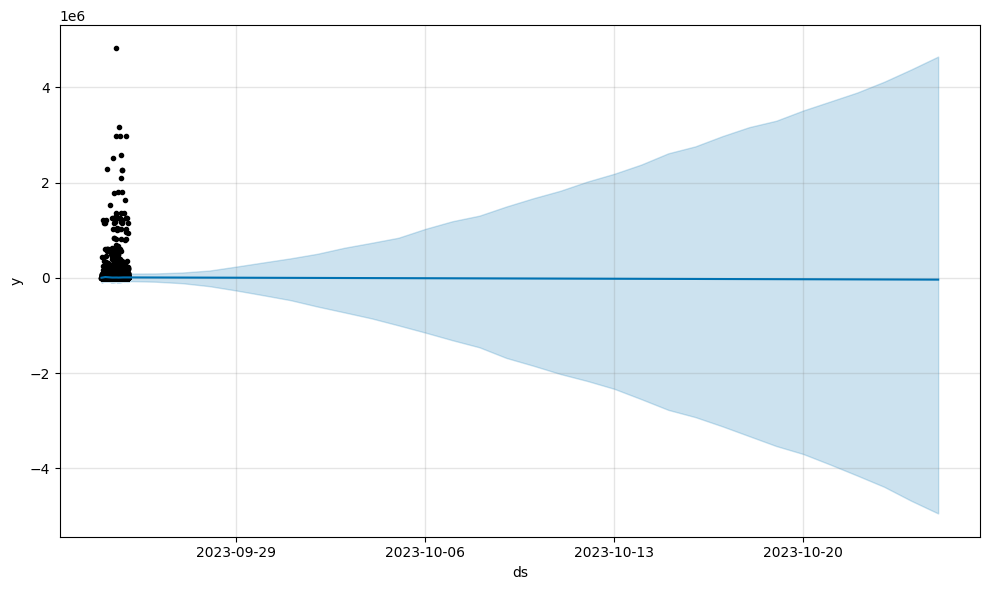

In [3]:
from prophet import Prophet

# Assuming data is the DataFrame with columns 'Timestamp' and 'Domain'
data = data.rename(columns={'ds': 'ds', 'Response_Size': 'y'})

# Initialize the model
model = Prophet()

# Fit the model with the data
model.fit(data)

# Make future predictions
future = model.make_future_dataframe(periods=30)  # Forecasting for the next 30 time points
forecast = model.predict(future)

# Visualize the results
fig = model.plot(forecast)

# Show the plot
plt.show()


In [4]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [5]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df['ds'],
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data[0], layout = layout)
    iplot(fig, show_link=False)

plotly_df(data, title = "Curle")

In [6]:
data['y'] = pd.to_numeric(data['y'], errors='coerce')
data.dropna(inplace=True) 

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['y'], order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

forecast = model_fit.forecast(steps=10)
print(forecast)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                42348
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -533234.587
Date:                Sun, 24 Sep 2023   AIC                        1066481.174
Time:                        23:47:33   BIC                        1066533.095
Sample:                             0   HQIC                       1066497.564
                              - 42348                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8285      0.001  -1038.807      0.000      -0.830      -0.827
ar.L2         -0.6615      0.001   -650.398      0.000      -0.663      -0.659
ar.L3         -0.4955      0.001   -456.728      0.0

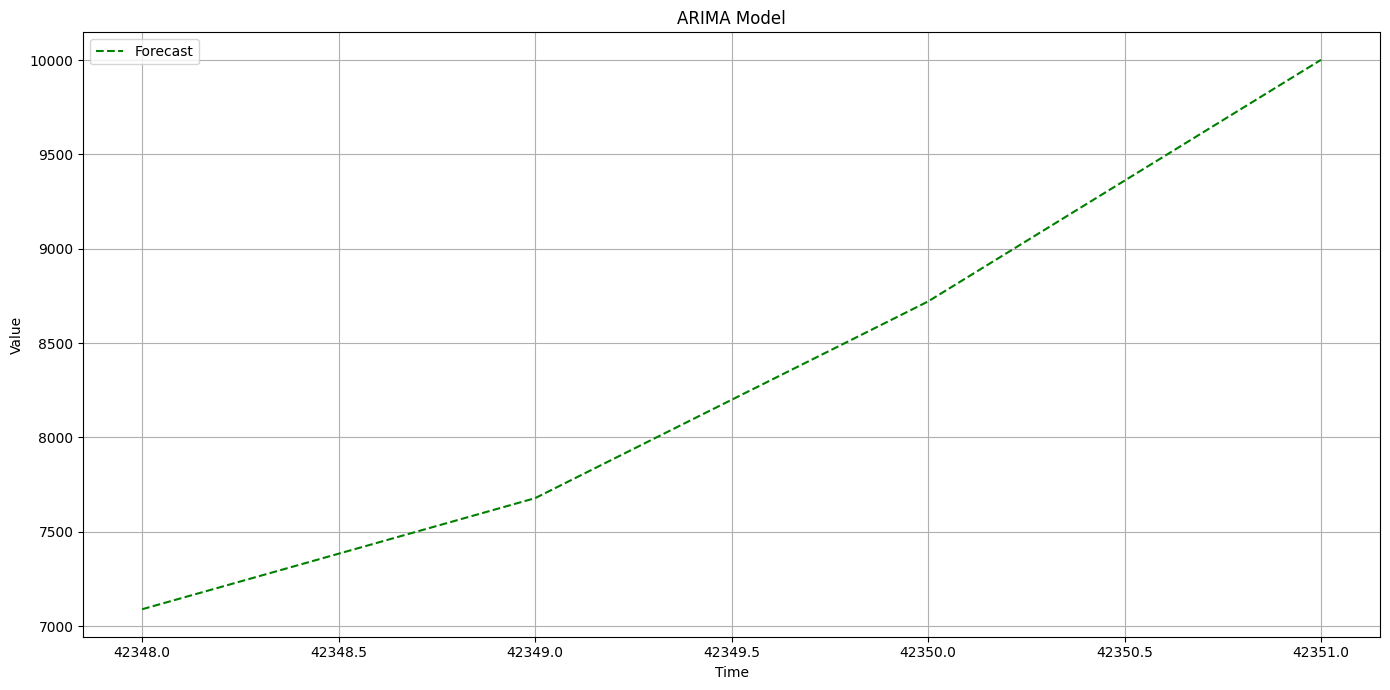

In [7]:
# Получите прогнозы
forecast_steps = 4
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = range(len(data), len(data) + forecast_steps)

# Визуализация
plt.figure(figsize=(14,7))

# Исходные данные
#plt.plot(data['y'], label='Actual', color='blue')

# Подгонка модели
#plt.plot(model_fit.fittedvalues, color='red', label='Fitted')

# Прогнозы
plt.plot(forecast_index, forecast, color='green', linestyle='--', label='Forecast')

plt.title('ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True)
plt.show()

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

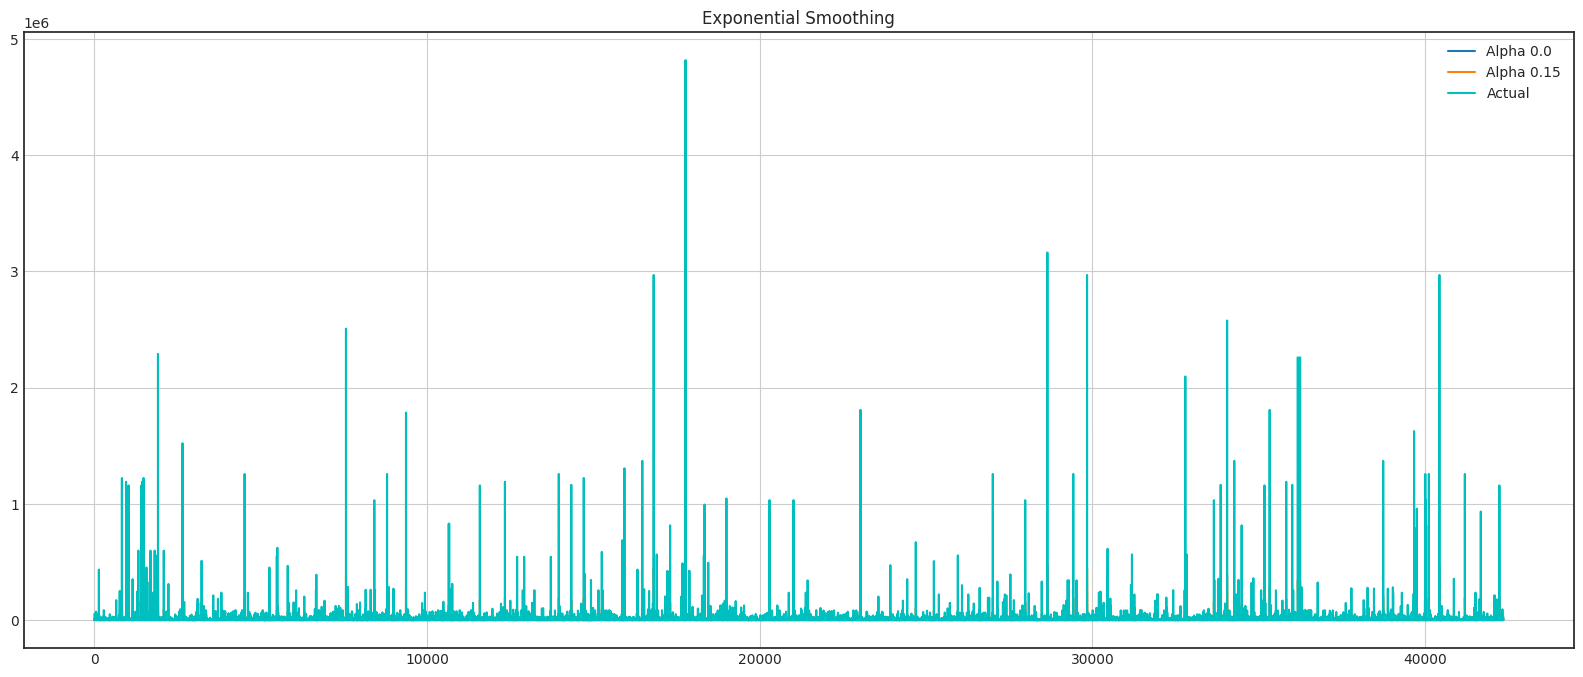

In [27]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.0, 0.15]:
        plt.plot(exponential_smoothing(data.y, alpha), label="Alpha {}".format(alpha))
    plt.plot(data.y.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

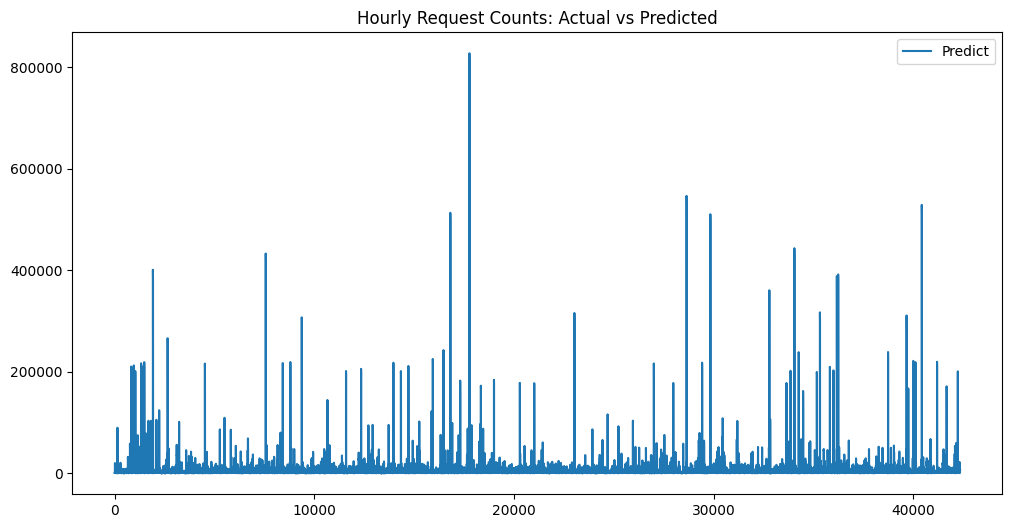

42348     7089.142868
42349     7677.981438
42350     8720.791794
42351    10001.769559
42352     6718.612362
42353     7652.747573
42354     7973.080789
42355     8119.917661
42356     8197.585347
42357     8112.435461
Name: predicted_mean, dtype: float64


In [23]:
data['Predict'] = model_fit.predict(start=1, end=len(data), dynamic=False)

# Plot actual vs predicted values
data[['Predict']].plot(figsize=(12, 6))
plt.title("Hourly Request Counts: Actual vs Predicted")
plt.show()

# For forecasting future values
forecast = model_fit.forecast(steps=10)
print(forecast)